# Smart elevator

The goal of this project is to model an elevator to build a prediction engine for which floor is the best resting floor at any time.

* When people call an elevator this is considered a demand
* When the elevator is vacant and not moving between floors, the current floor is considered its resting floor.
* When the elevator is vacant, it can stay at the current position or move to a different floor
* The prediction model will determine what is the best floor to rest on.
* The requirement isn't to complete this system but to start building a system that would feed into the training and prediction of an ML system.
* You will need to talk through your approach, how you modelled the data and why you thought that data was important, provide endpoints to collect the data and a means to store the data. Testing is important and will be used verify your system.

## In short

* connect to a database
* crud some data (perhaps using flask)
* add some flair with a business rule or two
* have the data in a suitable format to feed to a prediction training algorithm

## Marking

* You will be marked on how well your tests cover the code and how useful they would be in a prod system.
* You will need to provide a database of some sort. This could be as simple as a sqlite or as complicated as a docker container with a migrations file.
* Fork this repo and begin from there.
* For your submission, invite my user to review your github PR(s) into the main branch. I will review it, offer any feedback and if it passes PR you will proceed onto the next step.
* Github user to invite is @dchecks

# Analysis logic

Elevators can be used in several places, for example:

* Company building.
* Apartment building.
* Mall.

The place is important because the people behavior would be different in function of the place and the activities that they do on it.  Let’s analyze what could happen depending on which building the elevator is located, and we will try to find a common pattern to make a model that can make a good performance in this scenarios.

## Company building

In this building, most of people are workers, so usually they have a regular schedule to use the elevator:
* When they start working.
* At lunch time.
* When they finish working.

We can expect some regular data from this behavior. On the other hand, we have some random data, that comes from:

* Special guests (not workers).
* If a worker arrives late or early.
* If a worker leaves early or late.
* A special shift.

## Apartment building

In this building, the data could be a little more “random”, but we could find some regular schedules to use the elevator:

* When the people go to work.
* May be some people can take their lunch at home.
* When the people come back to sleep.
* People habits (people who wake up early to make exercise, or another different activities that can add some regular use to the elevator).

We can expect some regular data from this behavior. On the other hand, we can expect more random data in this building, because some people doesn’t have regular schedules to go home at the end of the day, in addition, we could have:

* Some guests.
* Go out for travels or parties (in general other activities that people do in their rest).

## Mall

This building, could be a middle term between company and apartment buildings, because we have workers and no workers all the time, so we can expect a regular schedule to use the elevator from workers, but an irregular behavior from visitors, let’s started with the regular behavior:

* When workers start working.
* At lunch time (for workers and not workers).
* When workers finish working.
* People habits (people who go to the gym, or another different activities that can add some regular use to the elevator).

We can expect some regular data from this behavior. On the other hand, we have more random data, that comes from:

* Visitors at any time and any day basically.
* If a worker arrives late or early.
* If a worker leaves early or late.
* A special shift.

## Common features

We can see some common features, for example, no all the data would be random at first glance, so if we look this deeply, we could see that we can apply the next logic for all situations:

We will always have random data, because we can’t say that people will always make the same route every day, may be 2 users can have the same schedule, but they can arrive to work at different times, so we will have some noise from this behavior (even when we thought that this would be a regular behavior), so, a good approach, could be search for some patterns in the dataset, may be the use between Monday and Friday (even Saturday in some cases), and define some boundaries or ranges of use, that we can use later to normalize the rest of data and avoid introduce that noise in our model. 

# Importing zone

In [36]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from datetime import datetime, timedelta
import numpy as np

from sklearn import tree
from sklearn.model_selection import train_test_split

# Dataset exploration

In [37]:
elevator_dataset = pd.read_csv('elevator_operation_dataset.csv', index_col=[0])
print(elevator_dataset)

                      Date  demandFloor  endFloor  people
0     2021/12/01, 09:08:05            7         3       8
1     2021/12/01, 09:10:23            3        16       1
2     2021/12/01, 09:17:52           16        10       4
3     2021/12/01, 09:21:20           10        13       5
4     2021/12/01, 09:23:03           13        15       8
...                    ...          ...       ...     ...
5036  2021/12/10, 15:01:31            4        20       8
5037  2021/12/10, 15:10:44           20         1       7
5038  2021/12/10, 15:21:41            1         5       6
5039  2021/12/10, 15:23:59            5        15       7
5040  2021/12/10, 15:29:45           15         4       0

[5041 rows x 4 columns]


After a search on internet, I can’t find a dataset with the data of the operation of an elevator, so we will have to generate our own dataset. Making some explorations in the dataset, we can see it has the next columns:

* **Date:** Date and time of the movement.
* **demandFloor:** Floor from which we made the requirement.
* **endFloor:** Floor where some of all people leaves the elevator.
* **people:** Quantity of people remaining in the elevator.

Every row has a movement (from demandFloor to endFloor), when the elevator reach the endFloor but some people still there waiting for another endFloor, that endFloor is the demandFloor of the next row, but, when there is not people in the elevator, that endFloor is considered the rest floor, and the next row has the demandFloor after the rest floor,  that is the record what we want to predict to define the best rest floor.

# Trying to find a pattern

Let's plot two different days separately and try to find a pattern.

<AxesSubplot:xlabel='index', ylabel='demandFloor'>

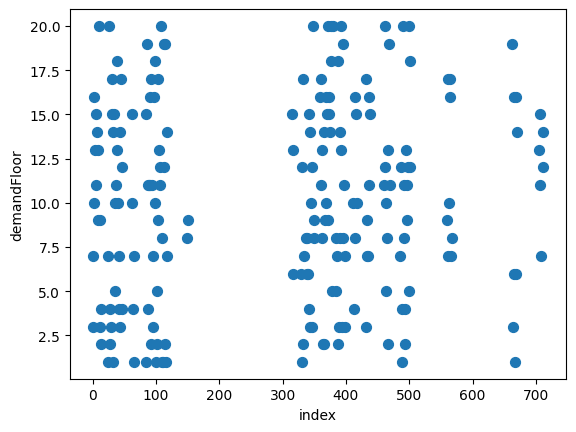

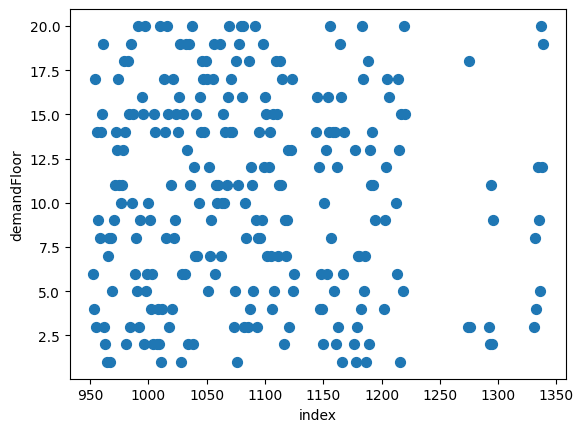

In [38]:
# One day
start_date = '2021/12/01'
end_date = '2021/12/01, 10:00:00'
# Select DataFrame rows between two dates
mask = (elevator_dataset['Date'] >= start_date) & (elevator_dataset['Date'] < end_date)
one_day_df = elevator_dataset.loc[mask]
one_day_df.reset_index().plot.scatter(x='index', y='demandFloor', s=50)

# Another day
start_date = '2021/12/03'
end_date = '2021/12/04, 10:00:00'
# Select DataFrame rows between two dates
mask = (elevator_dataset['Date'] >= start_date) & (elevator_dataset['Date'] < end_date)
other_day_df = elevator_dataset.loc[mask]
other_day_df.reset_index().plot.scatter(x='index', y='demandFloor', s=50)

We can't see some pattern or some kind of relattionship between the dates *(and I tried all the combinations possibles: date vs demandFloor, date vs endFloor, demandFloor vs endFloor)* , so, using these data (for at least with this shape) is quickly discarded. 

# Finding a way to use the data

We will create 4 new columns, timeHour, timeMinute, timeSecond and day. With this information we will make a tree of decisions, assuming that every week the behavior of the elevator remains approximately close, starting from the premise that people usually have habbits, so the elevator demand won't be the same, but it will have some similarities for the same days, for example, same behavior every monday, every tuesday, etc.

The time will be splitted and coding in three columns as follows:

* Hours = hour/23
* Minutes = minute/59
* Seconds = second/59

In [39]:
# Splitting the date and time in two different columns
elevator_dataset['Date'] = pd.to_datetime(elevator_dataset['Date'])

elevator_dataset['timeHour'] = elevator_dataset['Date'].apply(
    lambda x: x.time().hour/23
)

elevator_dataset['timeMinute'] = elevator_dataset['Date'].apply(
    lambda x: x.time().minute/59
)

elevator_dataset['timeSecond'] = elevator_dataset['Date'].apply(
    lambda x: x.time().second/59
)

elevator_dataset['day'] = elevator_dataset['Date'].dt.dayofweek

# Dropping the columns that we won't use
elevator_df = elevator_dataset.drop(['Date', 'endFloor', 'people'] , axis=1)

print(elevator_df)

      demandFloor  timeHour  timeMinute  timeSecond  day
0               7  0.391304    0.135593    0.084746    2
1               3  0.391304    0.169492    0.389831    2
2              16  0.391304    0.288136    0.881356    2
3              10  0.391304    0.355932    0.338983    2
4              13  0.391304    0.389831    0.050847    2
...           ...       ...         ...         ...  ...
5036            4  0.652174    0.016949    0.525424    4
5037           20  0.652174    0.169492    0.745763    4
5038            1  0.652174    0.355932    0.694915    4
5039            5  0.652174    0.389831    1.000000    4
5040           15  0.652174    0.491525    0.762712    4

[5041 rows x 5 columns]


# Making the model

In [40]:
from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()

#encoder_day = label_encoder.fit_transform(elevator_df['day'])

train_predictors = elevator_df.drop(['demandFloor'], axis = 1)

dummy_encoded_train_predictors = pd.get_dummies(train_predictors)

In [41]:
y_target = elevator_df['demandFloor'].values
x_features_one = dummy_encoded_train_predictors.values

In [42]:
x_train, x_validation, y_train, y_validation = train_test_split(x_features_one, y_target, test_size = .25, random_state = 1)

In [43]:
elevator_tree = tree.DecisionTreeClassifier()
elevator_tree = elevator_tree.fit(x_features_one, y_target)

In [44]:
elevator_tree_accuracy = round(elevator_tree.score(x_features_one, y_target), 4)
print('Accuracy: %0.4f' % (elevator_tree_accuracy))

Accuracy: 0.9946


# Testing

We will use the test dataset to test the model again, but this time, we will measure the waiting time every time that an user call the elevator from its rest position, and we will compare with IA and wihiout IA.

In [45]:
# length train data = 3780/ length validation data = 1261
test_df = elevator_df.iloc[3780:,:]
# Adding people data to the test df
test_df['people'] = elevator_dataset['people'].iloc[3780:].values
print(test_df)

      demandFloor  timeHour  timeMinute  timeSecond  day  people
3780           17  0.391304    0.016949    0.237288    2       8
3781            5  0.391304    0.135593    0.135593    2       6
3782           20  0.391304    0.271186    0.796610    2       8
3783            2  0.391304    0.457627    0.152542    2       3
3784            8  0.391304    0.508475    0.610169    2       0
...           ...       ...         ...         ...  ...     ...
5036            4  0.652174    0.016949    0.525424    4       8
5037           20  0.652174    0.169492    0.745763    4       7
5038            1  0.652174    0.355932    0.694915    4       6
5039            5  0.652174    0.389831    1.000000    4       7
5040           15  0.652174    0.491525    0.762712    4       0

[1261 rows x 6 columns]


/tmp/ipykernel_30515/1073339025.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['people'] = elevator_dataset['people'].iloc[3780:].values


In [46]:
# Save total ditance and movements from the rest positions without IA
# Elevator start at floor 1, wait time from rest to current floor,
# and acumulated distance
floor_noIA = [1]
time_noIA =['00:00']
dist_noIA = 0

# Save total ditance and movements from the rest positions with IA
# Elevator start at floor 1, wait time from rest to current floor,
# and acumulated distance
floor_IA = [1]
time_IA = ['00:00']
dist_IA = 0

# Create date just to measure time
timeRef = datetime(1,1,22,0,0,0)

# Iterating through df
for i in test_df.index:
    # We only check for distances if the elevator is in rest position
    if test_df['people'][i] == 0:
        # Updte no IA time ---------------------------------
        floor_noIA.append(test_df['demandFloor'][i])
        time_noIA.append((timeRef + timedelta(days=abs(test_df['demandFloor'][i]-floor_noIA[-2])*0.0004)).strftime('%M:%S'))
        dist_noIA += abs(test_df['demandFloor'][i]-floor_noIA[-2])
        # Updte IA time ---------------------------------
        # Predict the possible value for demand floor and go there
        # Check the current hour
        # Check in what half hour we are, example: 09:00 or 09:30
        if (test_df['timeMinute'][i]) < (30/59):
            timeMinute = 0.0
        else:
            timeMinute = round(30/59, 6)
        # Go to the predicted floor for that hour
        predicted_floor = elevator_tree.predict([[test_df['timeHour'][i], timeMinute, 0.0, test_df['day'][i]]])[0]
        floor_IA.append(predicted_floor)
        # Now go to the floor where the call was made
        floor_IA.append(test_df['demandFloor'][i])
        time_IA.append((timeRef + timedelta(days=abs(test_df['demandFloor'][i]-floor_IA[-2])*0.0004)).strftime('%M:%S'),)
        dist_IA += abs(test_df['demandFloor'][i]-floor_IA[-2])
        
performance_df = pd.DataFrame()
performance_df['floorLogNoIA'] = floor_noIA
performance_df['timeLogNoIA'] = time_noIA
performance_df['timeLogIA'] = time_IA

performance_df['floatTimeLogNoIA'] = performance_df['timeLogNoIA'].apply(
    lambda x: float(x[:2]) + float(x[3:])/59 if(x != '--') else '--'
)
performance_df['floatTimeLogIA'] = performance_df['timeLogIA'].apply(
    lambda x: float(x[:2]) + float(x[3:])/59 if(x != '--') else '--'
)

maxNoIA = performance_df['floatTimeLogNoIA'].max()
minNoIA = performance_df['floatTimeLogNoIA'].min()
meanNoIA = performance_df['floatTimeLogNoIA'].mean()
medianNoIA = performance_df['floatTimeLogNoIA'].median()

maxIA = performance_df['floatTimeLogIA'].max()
minIA = performance_df['floatTimeLogIA'].min()
meanIA = performance_df['floatTimeLogIA'].mean()
medianIA = performance_df['floatTimeLogIA'].median()

print('total calls: {}'.format(len(performance_df)))
print('total floors traveled:')
print('whitout IA {} | whit IA {}'.format(
    dist_noIA,
    dist_IA
    )
)

print('time without IA [mm:ss] | time with IA [mm:ss]')
print('max: {}:{} | {}:{}'.format(
    int(maxNoIA),
    int((maxNoIA-int(maxNoIA))*59),
    int(maxIA),
    int((maxIA-int(maxIA))*59)
    )
)
print('min: {}:{} | {}:{}'.format(
    int(minNoIA),
    int((minNoIA-int(minNoIA))*59),
    int(minIA),
    int((minIA-int(minIA))*59)
    )
)
print('mean: {}:{} | {}:{}'.format(
    int(meanNoIA),
    int((meanNoIA-int(meanNoIA))*59),
    int(meanIA),
    int((meanIA-int(meanIA))*59)
    )
)
print('median: {}:{} | {}:{}'.format(
    int(medianNoIA),
    int((medianNoIA-int(medianNoIA))*59),
    int(medianIA),
    int((medianIA-int(medianIA))*59)
    )
)


total calls: 137
total floors traveled:
whitout IA 878 | whit IA 802
time without IA [mm:ss] | time with IA [mm:ss]
max: 10:22 | 10:55
min: 0:0 | 0:0
mean: 3:40 | 3:21
median: 3:27 | 2:51


# Conclusions

We can see that the IA model has the longest waiting time obtained and it has a mean waiting time higher, however, we can see that its median is lower, this means, that the half of times that the elevator was called, the waiting time was lower than 2 minutes 51 seconds (68 calls). On the other hand, we can see that the elevator does more movements between floors because it has to travel to the predicted floor at certains hours.